In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
from scipy import sparse
import inference
import cluster
import generation
import graph_tool as gt
from graph_tool import inference as gtinference


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Matplotlib settings

basic_line_color = '#808080'
black = '#222222'
darkgray = '#A9A9A9'
highlight = '#00B2EE'

color0 = '#1f78b4'
color1 = '#b2df8a'
color2 = '#a6cee3'

plt.rc('figure', figsize=(8, 5))
plt.rc('font', size=16)
plt.rc('font', family='sans-serif')
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.edgecolor'] = basic_line_color
plt.rcParams['xtick.color'] = basic_line_color
plt.rcParams['ytick.color'] = basic_line_color
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['lines.markersize'] = 12

%config InlineBackend.figure_format = 'retina'

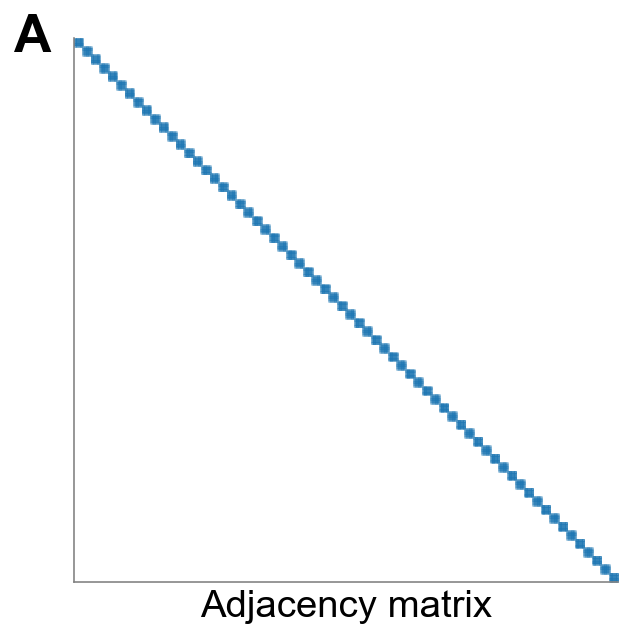

In [4]:
# build clique graph
n_cliques = 64
nodes_per_clique = 10
clique = scipy.asmatrix(scipy.ones((nodes_per_clique,nodes_per_clique),dtype=int))
A = clique
for i in range(n_cliques-1):
    A = scipy.sparse.block_diag((A,clique))
plt.figure()
ax = plt.gca()
plt.spy(A,ms=0.001, rasterized=True, color=color0)
plt.xticks([])
plt.yticks([])
plt.xlabel('Adjacency matrix')
ax.annotate('A', (-0.11, 1), xycoords='axes fraction', va='center', size=26, weight='bold')
plt.savefig("64cliques.pdf",dpi=450)

In [8]:
GT_graph = gt.Graph()
GT_graph.add_edge_list(scipy.transpose(A.nonzero()))
blockmodel_state = gtinference.minimize_nested_blockmodel_dl(GT_graph)
pvec = blockmodel_state.print_summary()
blockmodel_state.draw(output="dendrogram_MDL.png")

l: 0, N: 640, B: 65
l: 1, N: 65, B: 23
l: 2, N: 23, B: 11
l: 3, N: 11, B: 5
l: 4, N: 5, B: 2
l: 5, N: 2, B: 1


(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff0790d2278, at 0x7feff8071e80>,
 <Graph object, directed, with 747 vertices and 746 edges, at 0x7ff058513b00>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7ff058513b00, at 0x7ff0512f8d30>)

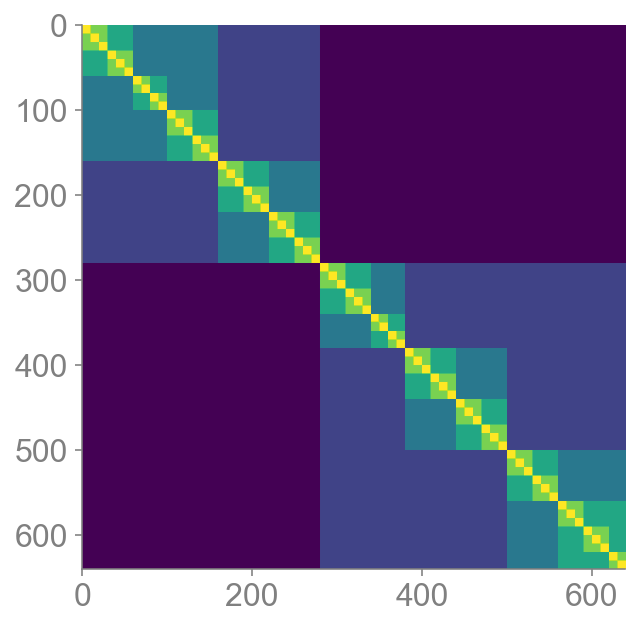

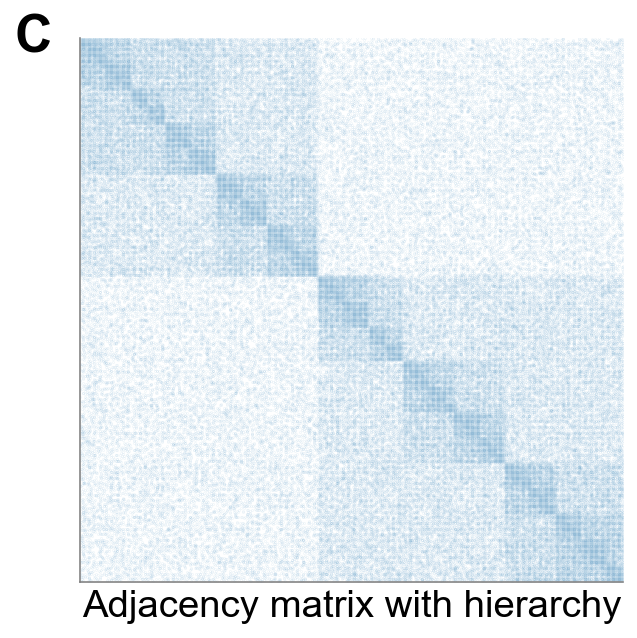

In [15]:
# read out partition from nested blockmodel and create a adjacency matrix with a hierarchy of that structure
pvec_list = blockmodel_state.get_state()
pvec_list_exp = []
omega = 0
H0 = np.eye(n_cliques*nodes_per_clique)
for pvec in pvec_list:
    part = cluster.Partition(pvec)
    H0 = H0 @ part.H    
    pvec_list_exp.append(np.nonzero(H0)[1])
    omega = omega + H0 @ H0.T
omega = omega / np.max(omega)
sorted_indices = np.lexsort(pvec_list_exp)

sorted_omega = omega[np.ix_(sorted_indices,sorted_indices)]
plt.imshow(sorted_omega)

Ahier = 1* np.random.rand(sorted_omega.shape[0],sorted_omega.shape[1]) <= sorted_omega
plt.figure()
ax= plt.gca()
plt.spy(Ahier,markersize=0.05, marker=".", color=color0, rasterized=True)
plt.xticks([])
plt.yticks([])
plt.xlabel('Adjacency matrix with hierarchy')
ax.annotate('C', (-0.12, 1), xycoords='axes fraction', va='center', size=26, weight='bold')
plt.savefig("Ahier.pdf",dpi=450)

AttributeError: 'AxesImage' object has no property 'ms'

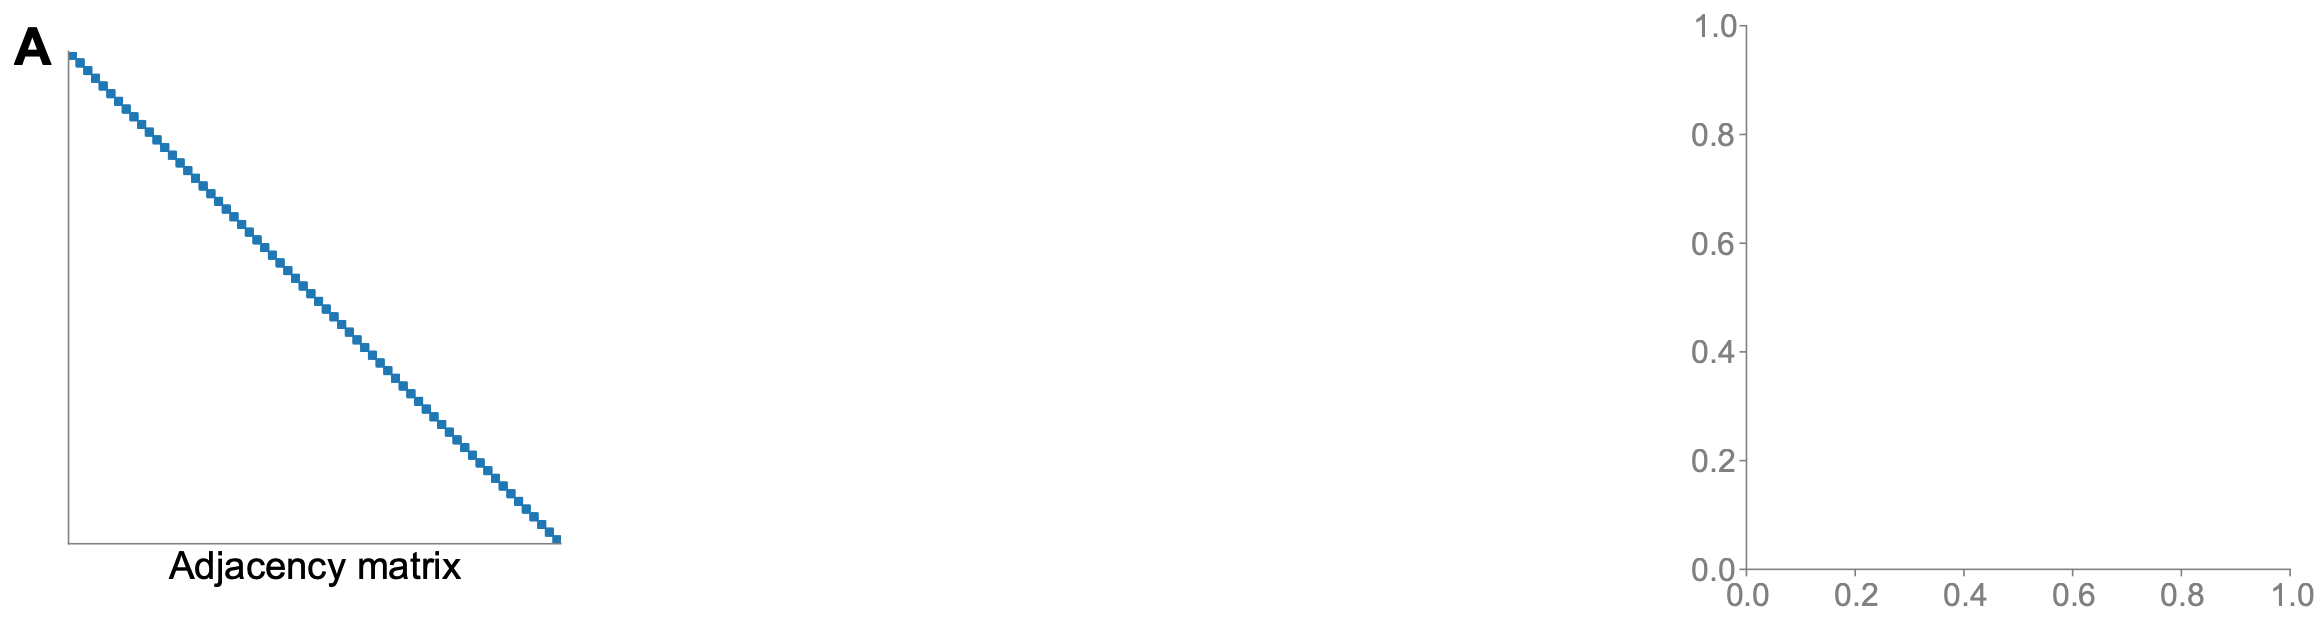

In [6]:
plt.switch_backend("cairo")
fig = plt.figure(figsize=(21, 5))
widths = [5, 8, 8]
heights = [5]
spec5 = fig.add_gridspec(ncols=3, nrows=1, width_ratios=widths,
                           height_ratios=heights)
row = 0
col=0
ax = fig.add_subplot(spec5[row, col])

plt.spy(A, ms=.01, rasterized=True, color=color0)
plt.xticks([])
plt.yticks([])
plt.xlabel('Adjacency matrix')
ax.annotate('A', (-0.11, 1), xycoords='axes fraction', va='center', size=26, weight='bold')

col=2
ax = fig.add_subplot(spec5[row, col])

plt.spy(Ahier, ms=.01, rasterized=True, color=color0)
plt.xticks([])
plt.yticks([])
plt.xlabel('Adjacency matrix with hierarchy')
ax.annotate('C', (-0.12, 1), xycoords='axes fraction', va='center', size=26, weight='bold')


col=1
ax = fig.add_subplot(spec5[row, col])
plt.xticks([])
plt.yticks([])
plt.xlabel('Inferred Dendrogram (MDL)')
ax.annotate('B', (-0.11, 1), xycoords='axes fraction', va='center', size=26, weight='bold')
blockmodel_state.draw(mplfig=ax)

# fig.tight_layout()
plt.savefig('Figure1.pdf')